In [2]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import torch.nn as nn
import numpy as np

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
import seaborn as sns
from scipy import ndimage

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [3]:
# set path to models and initialise arrays
# model_path = '../storage/models/kaandorp_data/ph_cdc_sd/additional_features/phill_2800_10595/no_reg_corr_sd/'
model_path = '../storage/models/kaandorp_data/sd/additional_features/sd_2000_2400_2900_3200/'
model = th.load(os.sep.join([model_path, 'model.pt']))
mu = th.load(os.sep.join([model_path, 'mu.th']))
std = th.load(os.sep.join([model_path, 'std.th']))
_ = model.eval()  # mandatory, see torch.load doc

In [12]:
# read in tensor data
rans_path = '/home/leonriccius/Desktop/SquareDuct/Re3500_kOmega_50_ml_sd_only/'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/rans_kaandorp/PeriodicHills/Re5600_kOmega_150/'

rans_time = max([int(entry) for entry in os.listdir(rans_path) if entry.isnumeric()])
rans_time = '50000'

with NoStdStreams():
    u = pre.readVectorData(rans_time, 'U', rans_path)
    grid = pre.readCellCenters(rans_time, rans_path)
    rs = pre.readSymTensorData(rans_time, 'turbulenceProperties:R', rans_path).reshape(-1, 3, 3)
    grad_u = pre.readTensorData(rans_time, 'grad(U)', rans_path)
    grad_k = pre.readVectorData(rans_time, 'grad(k)', rans_path)
    grad_p = pre.readVectorData(rans_time, 'grad(p)', rans_path)
    y_wall = pre.readScalarData(rans_time, 'wallDistance', rans_path)
    k = pre.readScalarData(rans_time, 'k', rans_path)
    omega = pre.readScalarData(rans_time, 'omega', rans_path)  # 'epsilon' or 'omega'
    epsilon = omega * k * 0.09  # 0.09 is beta star
    nu = 3.5714285714285714e-04

# get b_rans
b_rans = barymap.anisotropy(rs, k)

# calculate mean rate of strain and rotation tensors
s = 0.5 * (grad_u + grad_u.transpose(1, 2))
r = 0.5 * (grad_u - grad_u.transpose(1, 2))

# normalize s and r
s_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * s
r_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * r
grad_k_hat = (th.sqrt(k) / epsilon).unsqueeze(1) * grad_k

# capping tensors
s_hat = cap_tensor(s_hat, 6.0)
r_hat = cap_tensor(r_hat, 6.0)

# get invariants and remove features
inv_fs1 = get_invariants(s_hat, r_hat)
for i in [3,4][::-1]:  # must be in reverse of indices are wrong
    inv_fs1 = th.cat((inv_fs1[:, :i - 1], inv_fs1[:, i:]), dim=1)

inv_fs2 = get_invariants_fs2(s_hat, r_hat, grad_k_hat)
for i in [4, 5, 6, 7, 8, 10, 11, 12][::-1]:  # must be in reverse of indices are wrong
    inv_fs2 = th.cat((inv_fs2[:, :i - 1], inv_fs2[:, i:]), dim=1)

inv_fs3 = get_invariants_fs3(s, r, rs, u, grad_u, grad_p, grad_k, k, epsilon, y_wall, nu)

inv = th.cat((inv_fs1, inv_fs2, inv_fs3), dim=1)

# scale invariants
inv_mean_std = mean_std_scaling(inv, mu=mu, std=std)[0]

t = get_tensor_functions(s_hat, r_hat)
t_zero_trace = enforce_zero_trace(t.reshape(-1,10,3,3))
b_pred,_ = model(inv_mean_std, t_zero_trace.reshape(-1,10,9))
b_pred = b_pred.reshape(-1,3,3).detach()



# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_fs1_fs2_fs3_reduced/SquareDuct/3500'
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

enforcing 0 trace ...


In [13]:
b_real = b_pred.clone()

for i in range(5):
    b_real = enforce_realizability(b_real)

Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True


In [14]:
print('max b:       {:.4f}'.format(th.max(b_pred[:,0,0])))
print('max b_real:  {:.4f}'.format(th.max(b_real[:,0,0])))

max b:       0.6580
max b_real:  0.6519


In [15]:
# filter b_pred
nx, ny = 50, 50
b_real_reshaped = b_real.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_filt = th.from_numpy(filterField(b_real_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)

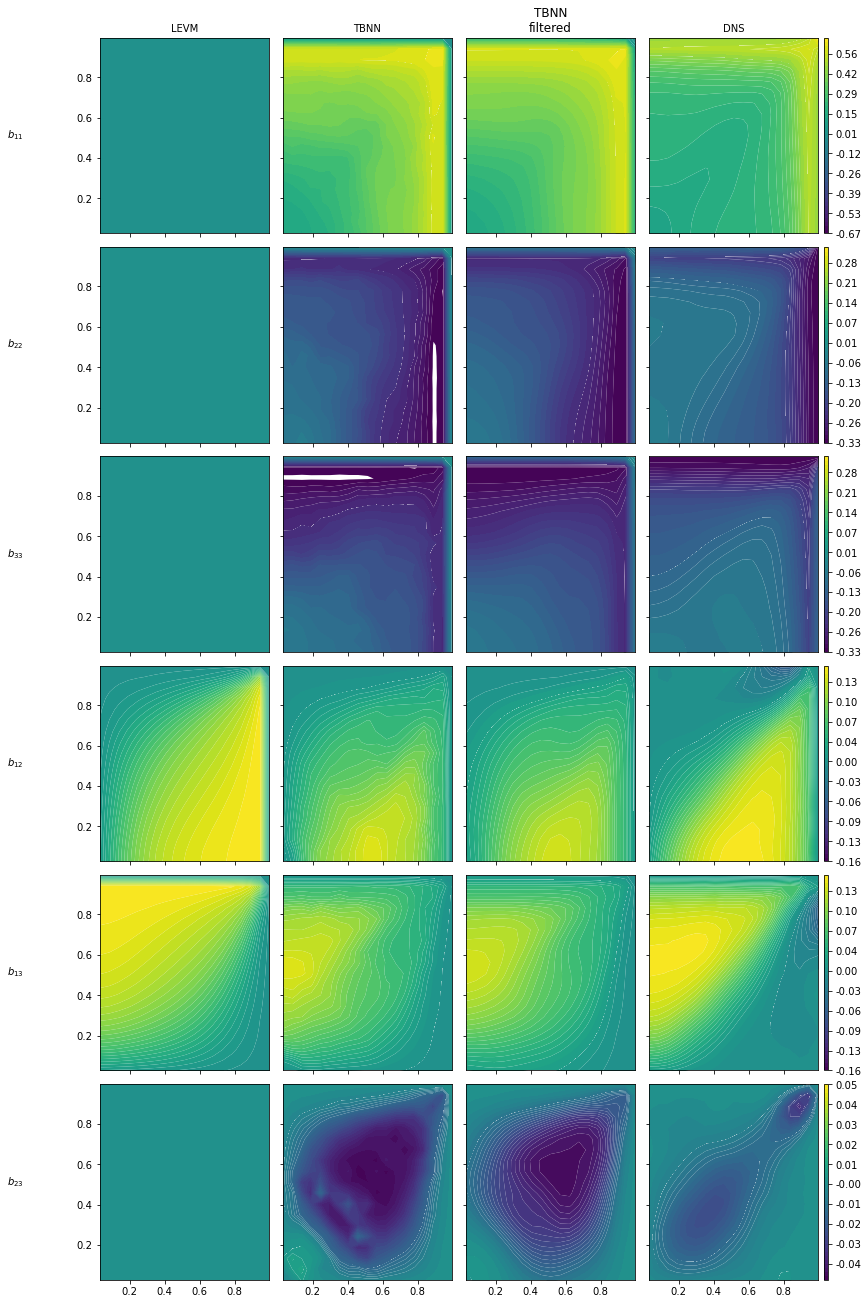

In [16]:
# define refinement level of interpolation grid and how much of boundary should be but off
ref = 20
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid[:,1].numpy()), np.max(grid[:,1].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(grid[:,2].numpy()), np.max(grid[:,2].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
# grid_y_shifted = cdc_interp(grid_x, re='7900')*(y_max - grid_y)/y_max + grid_y
# grid_y = grid_y_shifted

# interpolate b tensor
grid_b_rans = griddata(grid[:,1:3], b_rans.numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)
grid_b_pred = griddata(grid[:,1:3], b_pred.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real = griddata(grid[:,1:3], b_real.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real_filt = griddata(grid[:,1:3], b_real_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_dns = griddata(grid[:,1:3], b_dns.numpy(), (grid_x, grid_y), method = 'linear')

# get min an max of (b_pred, b_test) for colormap
tmp = np.vstack((grid_b_rans, grid_b_real, grid_b_dns))
# b_min = np.min(tmp, axis=(0,1))
# b_max = np.max(tmp, axis=(0,1))
b_max = np.max(np.abs(tmp), axis=(0,1))
b_min = -np.max(np.abs(tmp), axis=(0,1))

components = [[0,0], [1,1], [2,2], [0,1], [0,2], [1,2]]
ncols = 4
nrows = len(components)
s = 1.

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*3.*nrows), sharex=True, sharey=True,
                       constrained_layout=True)   # set factor for ncols to 4.5 for true scaling of physical domain


for i, cmp in enumerate(components):
#     this_max = np.max(np.abs(b_min[cmp[0], cmp[1]]), np.abs(b_max[cmp[0], cmp[1]]))
#     this_min = - this_max
#     levels = np.linspace(this_min, this_max, 50)
    levels = np.linspace(b_min[cmp[0], cmp[1]], b_max[cmp[0], cmp[1]], 50)

    b_rans_plot = ax[i,0].contourf(grid_x, grid_y, grid_b_rans[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_plot = ax[i,1].contourf(grid_x, grid_y, grid_b_pred[:,:,cmp[0],cmp[1]], levels = levels)
#     b_pred_filt_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_pred_filt[:,:,cmp[0],cmp[1]], levels = levels)
#     b_real_plot = ax[2,i].contourf(grid_x, grid_y_shifted, grid_b_real[:,:,cmp[0],cmp[1]], levels = levels)
    b_real_filt_plot = ax[i,2].contourf(grid_x, grid_y, grid_b_real_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_dns_plot = ax[i,3].contourf(grid_x, grid_y, grid_b_dns[:,:,cmp[0],cmp[1]], levels = levels)
    
        # remove contour lines
    for contour in [b_rans_plot, b_pred_plot, b_real_filt_plot, b_dns_plot]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    fig.colorbar(b_dns_plot, ax=ax[i,:].flat, aspect=7.5*ncols, format='%.2f', pad=0.0)
x_off = -0.5
y_off = 0.5

ax[0,0].text(x_off,y_off, r'$b_{11}$', fontsize='medium', ha='left')
ax[1,0].text(x_off,y_off, r'$b_{22}$', fontsize='medium', ha='left')
ax[2,0].text(x_off,y_off, r'$b_{33}$', fontsize='medium', ha='left')
ax[3,0].text(x_off,y_off, r'$b_{12}$', fontsize='medium', ha='left')
ax[4,0].text(x_off,y_off, r'$b_{13}$', fontsize='medium', ha='left')
ax[5,0].text(x_off,y_off, r'$b_{23}$', fontsize='medium', ha='left')

ax[0,0].set_title(r'LEVM', fontsize='medium')
ax[0,1].set_title(r'TBNN', fontsize='medium')
ax[0,2].set_title(r'TBNN' '\n' r'filtered')
ax[0,3].set_title(r'DNS', fontsize='medium')

# save fig
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN/'
fig_name =  time() + 'additional_features_phill_2800.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

In [17]:
b_boundary = b_real_filt.reshape(ny,nx,3,3)[:,0]
b_boundary.shape

torch.Size([50, 3, 3])

In [18]:
# boundary list from curved backward facing step
b_list = [('side_walls', 'fixedValue_uniform'),
          ('inlet', 'cyclic'),
          ('outlet', 'cyclic'),
          ('side_left', 'symmetryPlane'),
          ('side_bottom', 'symmetryPlane')]

rans_time = '50000'

In [19]:
b_real_filt[:,1,2] = th.tensor([0.0])
b_real_filt[:,2,1] = th.tensor([0.0])

In [20]:
dd_case_path = rans_path  # '/home/leonriccius/Desktop/Re2800_kOmega_140_dns/'
writesymmtensor(b_real_filt, os.sep.join([dd_case_path, rans_time, 'b_ml']), b_list)

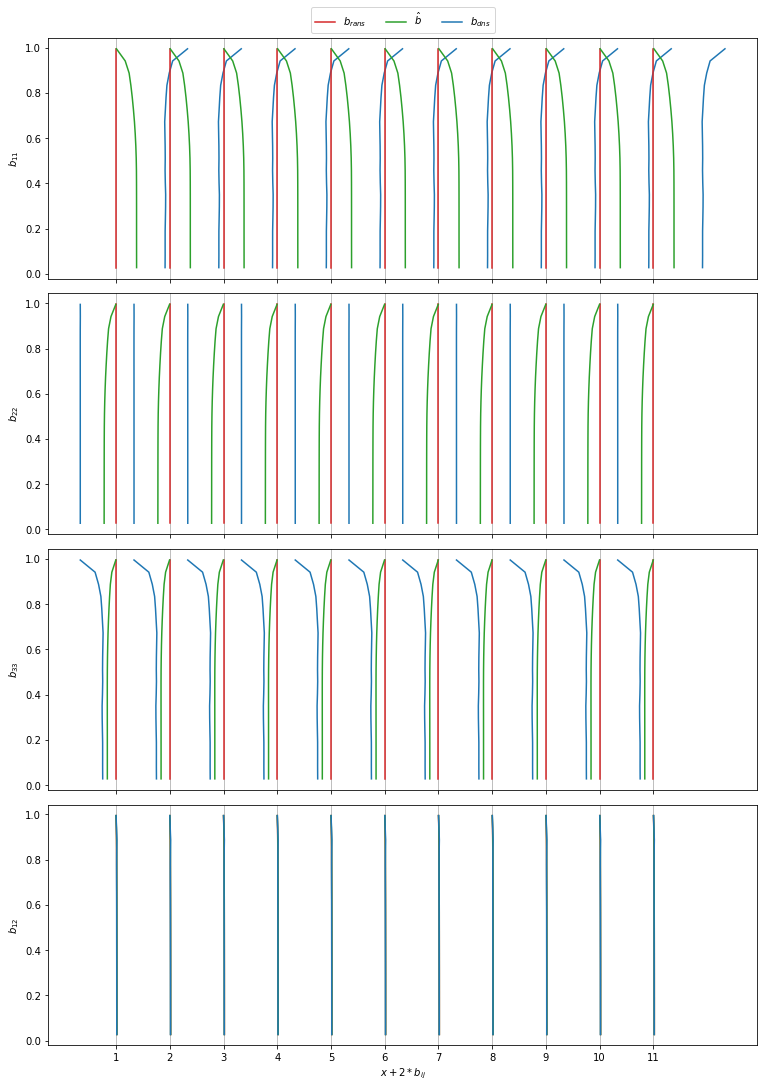

In [21]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = np.arange(1,12,1.0)
tol = 4e-2

# select components
components = [[0,0],[1,1],[2,2],[0,1]]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*7*ncols, 1.5*2.5*nrows),
                        sharex=True, sharey=True, constrained_layout=True)
plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_x[0] - val))
        x_val = grid_x[0, x_loc]

        # create mask and select points in the slice
        grid_slice = grid_y[:, x_loc]
        b_dns_slice = grid_b_dns[:, x_loc, cmp[0], cmp[1]]
        b_rans_slice = grid_b_rans[:, x_loc, cmp[0], cmp[1]]
        b_pred_slice = grid_b_real_filt[:, x_loc, cmp[0], cmp[1]]

#         # plot all bs for current slice
        axs[i].plot(2*b_rans_slice + val, grid_slice,
                   color=sns.color_palette()[3]) #, label = r'$b_{rans}')
        axs[i].plot(2*b_pred_slice + val, grid_slice,
                   color=sns.color_palette()[2]) #, label = r'$\hat b$')
        axs[i].plot(2*b_dns_slice + val, grid_slice,
                   color=sns.color_palette()[0]) #, label = r'$b_{dns}$')
        axs[i].set_ylabel(r'$b_{'+str(cmp[0]+1)+str(cmp[1]+1)+'}$')
    
    # plot lower and upper wall of hill and grid
#     barymap.plot_periodic_hills_boundaries(axs[i])
    axs[i].grid(axis='x')

# plot legend    
axs[0].legend([r'$b_{rans}$', r'$\hat b$', r'$b_{dns}$'], bbox_to_anchor=(0.5, 1.00), loc='lower center', ncol=3)

# plot xlabel
axs[-1].set_xlabel(r'$x + 2*b_{ij}$')

# save figure
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/'
fig_name = time() + '_phill_b_on_slices.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

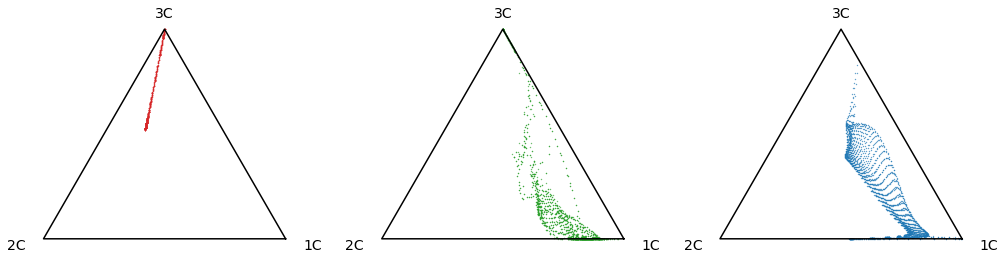

In [22]:
fig, ax = plt.subplots(1,3, figsize=(14,3.5), sharey=True, constrained_layout=True)

ax[0].axis('equal')
ax[0].axis('off')
ax[1].axis('equal')
ax[1].axis('off')
ax[2].axis('equal')
ax[2].axis('off')

barm_rans = BarMap()
# barm_rans.load_from_variable(b_rans[index], grid[index][:,0:2])
barm_rans.load_from_variable(b_rans, grid[:,0:2])
barm_rans.calculate_barycentric_coordinates()
barm_rans.plot_triangle(ax[0])
barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3], s=0.1)

barm_pred = BarMap()
# barm_pred.load_from_variable(b_pred[index].detach().numpy(), grid[index][:,0:2])
barm_pred.load_from_variable(b_real.numpy(), grid[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[1])
barm_pred.plot_data_points(ax[1], color=sns.color_palette()[2], s=0.1)

barm_dns = BarMap()
# barm_dns.load_from_path(path_dns)
barm_dns.load_from_variable(b_dns, grid[:,0:2])
barm_dns.calculate_barycentric_coordinates()
barm_dns.plot_triangle(ax[2])
barm_dns.plot_data_points(ax[2], color=sns.color_palette()[0], s=0.1)

for axs in ax.flat:
        axs.text(1.15, 0.0, '1C', fontsize=14,
            horizontalalignment='right', verticalalignment='top')
        axs.text(-0.15, 0.0, '2C', fontsize=14,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.9, '3C', fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
        
# save figure
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/abstract'
fig_name = time() + 'barmap_conv.svg'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='svg')

IndexError: index 17 is out of bounds for dimension 1 with size 17

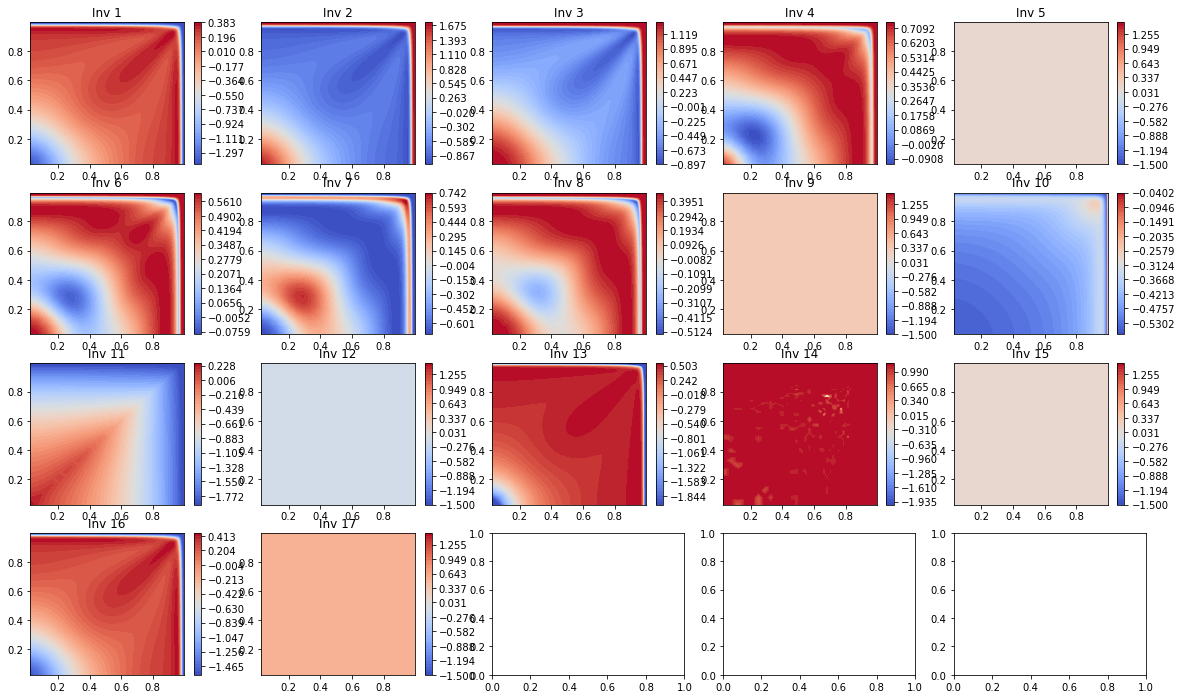

In [68]:
cmap = matplotlib.cm.get_cmap("coolwarm")

nrows, ncols = 4,5
fig, axs  = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3))

for i, ax in enumerate(axs.flat):
    inv_min = th.min(inv_mean_std[:, i])- 0.00001
    inv_max = th.max(inv_mean_std[:, i])*1.0001 - 0.00001
    if th.std(inv_mean_std[:,i])<0.00001:
        levels = np.linspace(-1.5, 1.5, 50)
    else:
        levels = np.linspace(inv_min, inv_max, 50)
    
    plot = ax.tricontourf(grid[:, 1], grid[:, 2], inv_mean_std[:, i], cmap=cmap, levels=levels)
    ax.set_title('Inv {}'.format(i + 1))
    fig.colorbar(plot, ax=ax)

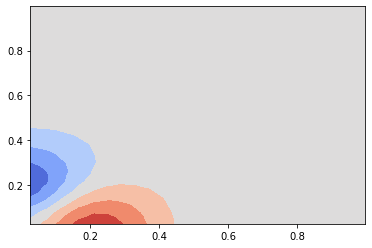

In [71]:
fig, ax = plt.subplots()
ax.tricontourf(grid[:, 1], grid[:, 2], inv_mean_std[:, 4], cmap=cmap) #, levels=levels)

In [54]:
inv[:,0]

tensor([8.0705e-02, 3.7689e-01, 8.7061e-01,  ..., 1.3410e-05, 5.4710e-06,
        1.2900e-06], dtype=torch.float64)